Кластеризация KMeans векторного представления картинки из датасета MINST.

# Задание

В данном задании необходимо кластеризовать изображения из двух разных датасетов (Mnist и Fashion Mnist). Чтобы это осуществить, мы воспользуемся автоэнкодером, который позволит получить векторные представления (эмбеддинги) изображений.

**Часть 1**

1. Загрузите изображения из датасетов Mnist и Fashion Mnist (можно использовать только изображения из обучающей части выборок), объедините их в один массив.
2. Сделайте необходимую предобработку данных (нормализацию и приведение к нужной размерности для подачи в автоэнкодер).
3. Создайте модель автоэнкодера, обучите ее в течение 10 эпох на сформированной выборке (содержащей изображения цифр и предметов одежды).
4. Перемешайте выборку и извлеките из нее 2000 случайных изображений, они будут использоваться для кластеризации. Получите векторные представления этих изображений с помощью энкодера.
5. Проведите серию экспериментов по кластеризации векторных представлений отобранных изображений с использованием алгоритма `KMeans`:
- протестируйте разное число кластеров (2, 5, 10, 20 и 30),
- для каждого эксперимента посчитайте значение метрики качества кластеризации `sklearn.metrics.silhouette_score`, запишите его в таблицу,
- для каждого эксперимента выведите двумерные представления изображений на график, цвет точки должен показывать принадлежность к кластеру, к которому изображение было отнесено.

Должен получиться примерно следующий результат:

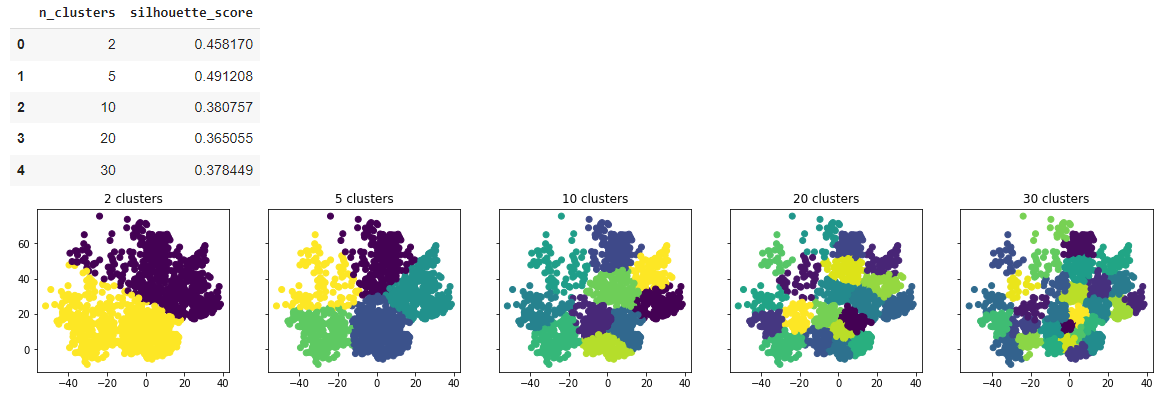

**Часть 2**

1. Возьмите разбиение всех изображений на 30 кластеров.
2. Выведите 10 случайных изображений из одного кластера (любого).
3. Выведите 2 "наиболее удаленных" друг от друга изображения из этого же кластера (т.е. расстояние между векторными представлениями которых максимально в рамках текущего кластера).

**Импорты**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose
from sklearn.metrics import silhouette_score, pairwise_distances

**Примеры кода**

Код для создания модели-автоэнкодера

In [ ]:
# Создадим функцию сборки блока построения сверточного энкодера
def encoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейронов сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагов сверточного слоя

    # Составим блок сети
    x = Conv2D(neu, kernel_size=kernel, strides= strides, padding='same')(xin) # Добавим 2D свертку
    x = BatchNormalization()(x)                                                # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                         # Добавим функцию активации

    # Вернем выходной тензор
    return x


# Создадим функцию сборки блока построения сверточного декодера
def decoderBlock(xin,        # Входной тензор
                 neu=8,      # Число нейронов сверточного слоя
                 kernel=3,   # Размер ядра сверточного слоя
                 strides=1): # Число шагов сверточного слоя

    # Составим блок сети
    x = Conv2DTranspose(neu, kernel_size=kernel, strides= strides, padding='same')(xin)  # Добавим обратную 2D свертку
    x = BatchNormalization()(x)                                                          # Добавим нормализацию по батчу
    x = LeakyReLU()(x)                                                                   # Добавим функцию активации

    # Вернем выходной тензор
    return x


# Создадим функцию сборки автоэнкодера, которая будет возвращать всю модель и энкодер отдельно
# latent_dim - длина вектора скрытого представления в автокодировщике
def create_encoder(latent_dim):
    
    # Создадим сверточный энкодер
    input_img = Input(shape=(28, 28, 1))                     # Добавим входной слой
    x = encoderBlock(input_img, neu=16, kernel=3, strides=1) # Добавим 1-й блок
    x = encoderBlock(x, neu=32, kernel=3, strides=2)         # Добавим 2-й блок
    flatten =Flatten()(x)                                    # Добавим Flatten
    encoded = Dense(latent_dim, activation='linear')(flatten)# Добавим выходной dense слой

    # Создадим сверточный декодер
    input_enc = Input(shape=(latent_dim,))                   # Добавим входной слой
    x = Dense(3136, name='dense_1')(input_enc)               # Добавим Dense-слой c 7х7х64 = 3136 нейронами
    x = Reshape((7, 7, 64))(x)                               # Решейпим 1D тензор в 3D тензор
    x = decoderBlock(x, neu=32, kernel=3, strides=1)         # Добавим 1-й блок
    x = decoderBlock(x, neu=16, kernel=3, strides=2)         # Добавим 2-й блок
    x = decoderBlock(x, neu=16, kernel=3, strides=2)         # Добавим 3-й блок
    decoded = Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x) # Добавим выходной слой

    # Соберем энкодер, декодер и автокодировщик
    encoderAEC = tf.keras.Model(input_img, encoded, name="encoder")                                     # Соберем энкодер
    decoderAEC = tf.keras.Model(input_enc, decoded, name="decoder")                                     # Соберем декодер
    autoencoder = tf.keras.Model(input_img, decoderAEC(encoderAEC(input_img)), name="autoencoder")      # Соберем автокодировщик
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')                                    # Скомпилируем автокодировщик

    return autoencoder, encoderAEC

**Решение**

In [ ]:
# Датасет
from tensorflow.keras.datasets import mnist
# Датасет
from tensorflow.keras.datasets import fashion_mnist
# Оптимизатор для обучения модели
from tensorflow.keras.optimizers import Adam
import random

In [ ]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train_f, y_train_f), (X_test_f, y_test_f) = fashion_mnist.load_data()
X_train=np.vstack((X_train,X_train_f))
y_train_f=y_train_f+10
y_train=np.hstack((y_train,y_train_f))

In [ ]:
# Нормировка
X_train = X_train.astype('float32')/255.
X_train = X_train.reshape(-1, 28, 28, 1)

In [ ]:
Mask=np.arange(X_train.shape[0])
random.shuffle(Mask)
TrainSize=int(X_train.shape[0]*0.95)

In [ ]:
Mask[:10]

array([ 66810,  11593, 119568, 108214,  63139, 115584,  78810,  60512,
        30548, 119513])

In [ ]:
autoencoder, encoderAEC = create_encoder(2)
autoencoder.compile(loss='mean_squared_error',optimizer=Adam(0.001),metrics=['accuracy'])
encoderAEC.summary()
autoencoder.summary()


history = autoencoder.fit(X_train[Mask][:TrainSize],X_train[Mask][:TrainSize],validation_data=(X_train[Mask][TrainSize:],X_train[Mask][TrainSize:]),epochs=10, batch_size=128)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                           

In [ ]:
SelectMask=np.random.randint(0,len(X_train),2000)
rnd_images=X_train[SelectMask]
rnd_labels=y_train[SelectMask]
rnd_images.shape

(2000, 28, 28)

In [ ]:
rnd_images_encode=encoderAEC.predict([rnd_images])
rnd_images_encode.shape

(2000, 2)

In [ ]:
n_cl=[2, 5, 10, 20, 30]

[]

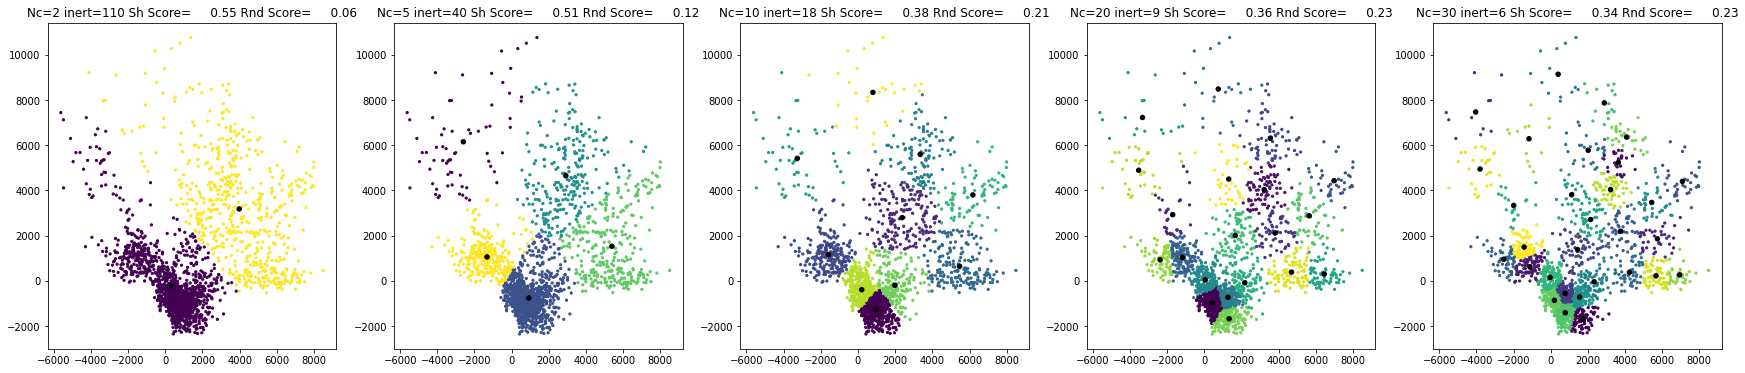

In [ ]:
from sklearn.metrics import silhouette_score,adjusted_rand_score

n_clusters_list = [2, 5, 10, 20, 30]
inertia_list = []
silhouette_score_list = []
adjusted_rand_score_list = []
KMean_models = []
predict_KMeans= []
selected_clusters=[]
fig, ax = plt.subplots(1,len(n_clusters_list),figsize=(30,6))
ax = ax.reshape(-1)
BlackDots=[[0,0,0]]*30

for i,n_clusters in enumerate(n_clusters_list):
  KMean_models.append(KMeans(n_clusters=n_clusters))
  selected_clusters.append(KMean_models[-1].fit_predict(rnd_images_encode))
  inertia_list.append(KMean_models[-1].inertia_)
  silhouette_score_list.append(silhouette_score(rnd_images_encode,selected_clusters[-1]))
  adjusted_rand_score_list.append(adjusted_rand_score(selected_clusters[-1],rnd_labels))
  ax[i].scatter(rnd_images_encode[:, 0], rnd_images_encode[:, 1], c=selected_clusters[-1], s=5)
  ax[i].scatter(KMean_models[-1].cluster_centers_[:, 0], KMean_models[-1].cluster_centers_[:, 1], c=BlackDots[:n_clusters], s=20)
  ax[i].set_title("Nc="+str(n_clusters)+" inert="+str(int(inertia_list[-1]/100000000))+" Sh Score={0:9.2f}".format(silhouette_score_list[-1])+" Rnd Score={0:9.2f}".format(adjusted_rand_score_list[-1]))
  

plt.plot()